# Procesamiento de Lenguaje Natural - **Semejanza entre texto**

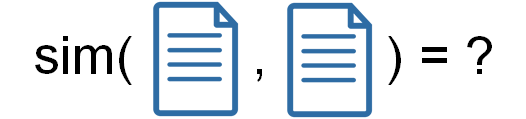

En este caso, vamos a trabajar con algunos pares de preguntas de un dataset de Quora preparado para la identificación de preguntas similares.

Obtención del dataset:

In [ ]:
import pandas as pd
import urllib.request

Si surgen problemas con la descarga del archivo, descargalo manualmente, subirlo al ambiente e invocar directamente la creación del ``df``.

In [ ]:
url = "https://drive.google.com/uc?export=download&id=1YBEL4ORmxWsfiJilVyMEWqqYcZJqknpv"

datapath = "train.csv"
urllib.request.urlretrieve(url, datapath)

In [ ]:
df = pd.read_csv("train.csv",usecols=['question1', 'question2','is_duplicate']) # recuerden que a Pandas también se le puede dar una url y dejar que baje el archivo

In [ ]:
question_pair1 = [df['question1'][2],df['question2'][2]]
question_pair2 = [df['question1'][10],df['question2'][10]]

question_list = [question_pair1[0],question_pair1[1],question_pair2[0],question_pair2[1]]

Para no cargar el dataset, podemos trabajar con los siquientes pares de preguntas de forma directa.

In [ ]:
question_pair1 = ['Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?', 
                  'I\'m a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?']

question_pair2 = ['How can I be a good geologist?	',
                  'What should I do to be a great geologist?']

question_list = ['Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
        'I\'m a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?',
        'How can I be a good geologist?	',
        'What should I do to be a great geologist?']

En la realidad, estas métricas no las vamos a implementar manualmente cada vez que las querramos usar, sino que vamos a tratar de recurrir a bibliotecas que ya las tengan implementadas. 

Vamos a ver algunas alternativas para el cálculo de las diferentes métricas.

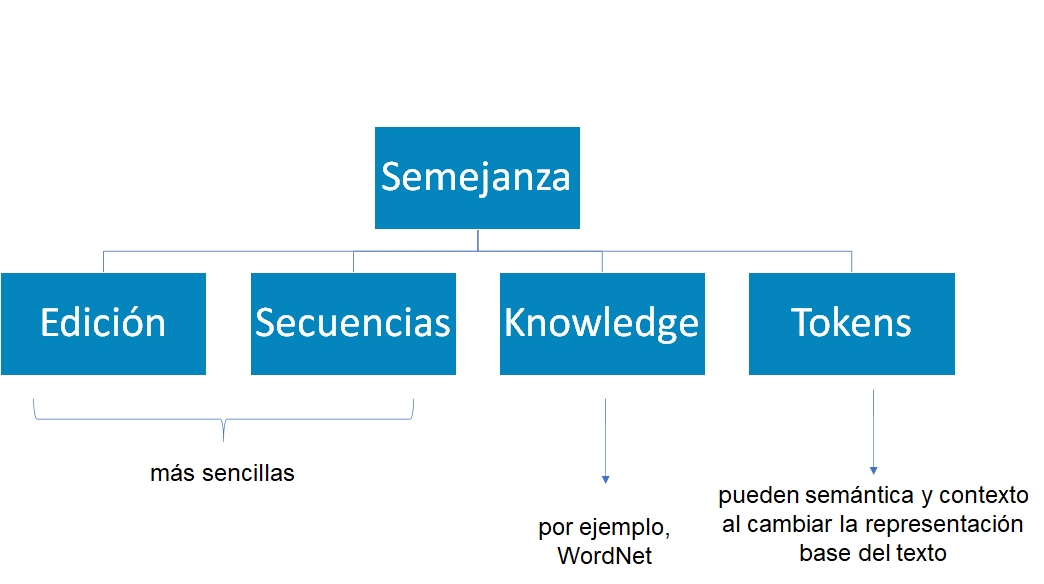


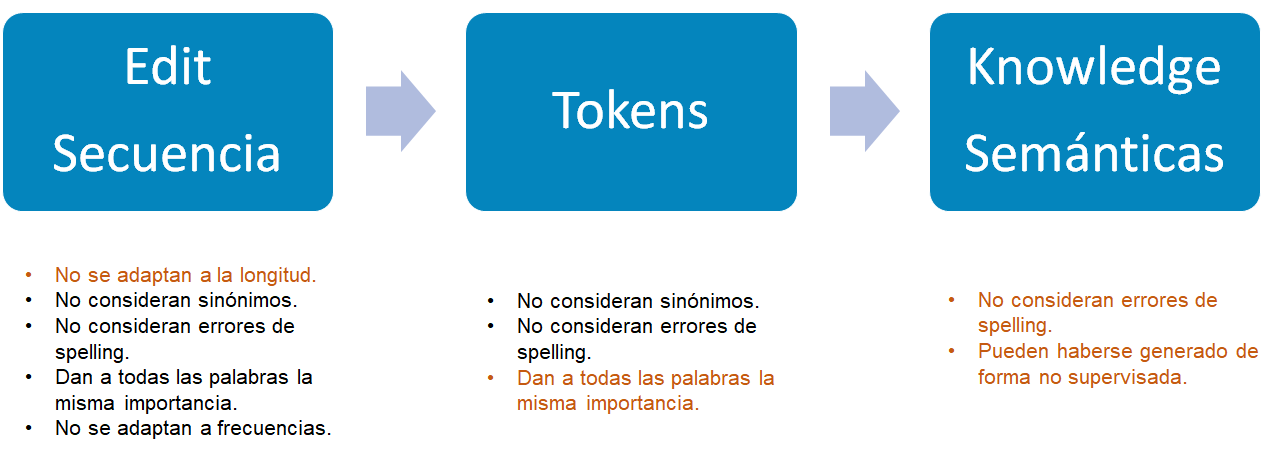

Vamos a ver que posibilidades nos ofrecen las diferentes bibliotecas.

### NLTK

Provee la funcionalidad para realizar diferentes cálculos de semejanza basados en Wordnet.



In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('wordnet_ic') # además de wordnet necesitamos el que calcula el IC

In [ ]:
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic

dog = wn.synsets('dog', pos=wn.NOUN)[0] # vamos a obtener la primera acepción
print(dog.definition())

cat = wn.synsets('cat', pos=wn.NOUN)[0]
print(cat.definition())

rose = wn.synsets('rose', pos=wn.NOUN)[0]
print(rose.definition())

flower = wn.synsets('flower', pos=wn.NOUN)[0]
print(flower.definition())

brown_ic = wordnet_ic.ic('ic-brown.dat') # el corpus ya está incluido


* ``Path similarity``. Asigna un valor entre [0,1] basado en el camino más corto que conecta dos conceptos en la jerarquía de hiperónimos/hiponóminos.

In [ ]:
print("rose flower",rose.path_similarity(flower))
print("rose dog",rose.path_similarity(dog))
print("rose cat",rose.path_similarity(cat))
print("cat dog",cat.path_similarity(dog))

* ``Wu-Palmer``. Mide la semejanza basada en la profundidad de los dos conceptos en la taxonomía y la de su *Least Common Subsumer* (LCS, el ancestro más específico). El LCS no necesariamente coincidirá con el camino más corto entre los dos conceptos. Es el ancestro común más profundo en la taxonomía, no el más cercano. 
  * Cuando multiples LCS existen, se selecciona aquel con el camino corto a la raíz más largo. 
  * Cuando el LCS tiene multiples caminos a la raíz, se toma el más largo.

In [ ]:
print("rose flower",rose.wup_similarity(flower))
print("rose dog",rose.wup_similarity(dog))
print("rose cat",rose.wup_similarity(cat))
print("cat dog",cat.wup_similarity(dog))

* ``Resnik``. Estima la semejanza como la probabilidad de encontrar al *Least Common Subsumer* (LCS) en un corpus grande. La probabilidad se conoce como *“Information Content”* (IC). Depende del corpus que fue utilizado para generar el IC. NLTK implementa esta y otras variaciones basadas en el IC.

In [ ]:
print("rose flower",rose.res_similarity(flower, brown_ic))
print("rose dog",rose.res_similarity(dog, brown_ic))
print("rose cat",rose.res_similarity(cat, brown_ic))
print("cat dog",cat.res_similarity(dog, brown_ic))

También podemos calcular la semejanza entre todos los pares de synsets derivados de cada una de las oraciones/textos.

In [ ]:
nltk.download('punkt')

In [ ]:
from nltk import word_tokenize
from itertools import product

topk1 = word_tokenize(question_pair1[0])
topk2 = word_tokenize(question_pair1[1])

allsyns1 = set(ss for word in topk1 for ss in wn.synsets(word)) # TODO! Ajustar por POS tag!
allsyns2 = set(ss for word in topk2 for ss in wn.synsets(word))

# for w in topk1:
#   for ss in wn.synsets(w):
#     print(w,"-->",ss.definition())

# el product "evita" tener que hacer explícito el doble for
sims = [(wn.wup_similarity(s1, s2) or 0, s1, s2) for s1, s2 in product(allsyns1, allsyns2)] # reemplazar por la métrica deseada

# for s in sims:
#   if s[0] > 0:
#       print(s[0],s[1].lemma_names(),s[2].lemma_names())

highest = max(sims)
print(highest[0],highest[1].definition(),highest[2].definition())



### spaCy

Una vez que tenemos pre-procesados los documentos, es posible calcular la semejanza del coseno entre ellos. Notar que la única posibilidad en este caso es obtener la semejanza por pares.

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')
doc1 = nlp(question_pair1[0])
doc2 = nlp(question_pair1[1])

print(doc1.similarity(doc2))

### Sklearn

Múltiples métricas disponibles:

* De ``scikit-learn``: `cityblock`, `cosine`, `euclidean`, `l1`, `l2`, `manhattan`. Estas métricas menos `nan_euclidean` soportan matrices ralas.

* De ``scipy.spatial.distance``: `braycurtis`, `canberra`, `chebyshev`, `correlation`, `dice`, `hamming`, `jaccard`, `kulsinski`, `mahalanobis`, `minkowski`, `rogerstanimoto`, `russellrao`, `seuclidean`, `sokalmichener`, `sokalsneath`, `sqeuclidean`, `yule`. Estas *NO* soportan matrices ralas.

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer() # necesitamos transformar nuestras oraciones de string a vectores numéricos, podemos usar el transformer que querramos
count_matrix = cv.fit_transform(question_pair1) 

# las métricas de sklearn vienen tanto propias de sklearn o importadas de scipy. En el caso de las de scipy, no aceptan matrices sparse, por eso el todense()
dist = pairwise_distances(count_matrix.todense(),metric='hamming') # cambiando metric podemos utilizar las otras que están disponibles

print(dist)

No necesariamente tenemos que darle un par de elementos, sino que podemos darle una lista y que nos calcule las semejanzas entre todos los pares posibles.

In [ ]:
count_matrix_list = cv.fit_transform(question_list)
dist_list = pairwise_distances(count_matrix_list.todense(),metric='hamming')

print(dist_list)

Estos resultados los podemos graficar. Aplica para las diferentes métricas.

Obvio que se pueden hacer más bonitos y más completos.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure()
fig = sns.heatmap(dist_list, annot=True,cmap="YlGnBu");
plt.title('Distances');

### Gensim

Provee funcionalidad para calcular la semejanza del coseno. Recordar que para utilizarla, es necesario crear el diccionario y el corpus.

In [ ]:
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

texts = [[text.lower() for text in simple_preprocess(doc)] for doc in question_list] # acá usamos la lista de oraciones

# usamos GenSimp ara crear el diccionario con los ids únicos.
dictionary = corpora.Dictionary(texts)

print(dictionary)
print(dictionary.token2id)

In [ ]:
from gensim.utils import simple_preprocess

tokenized_list = [simple_preprocess(doc) for doc in question_list] 

dicti = corpora.Dictionary()
corpus = [dicti.doc2bow(doc, allow_update=True) for doc in tokenized_list]

In [ ]:
from gensim import models

model_tfidf = models.TfidfModel(corpus) # creando el modelo con el corpus

corpus_tfidf = model_tfidf[corpus] # aplicando el modelo al mismo corpus con el que lo creamos
for doc in corpus_tfidf:
    print(doc)

In [ ]:
sims = gensim.similarities.Similarity('.',corpus=corpus_tfidf, num_features=len(dicti))
print(sims)

for s in sims:
  print(s)

Además de calcular la semejanza entre los documentos del corpus, podemos calcularla con documentos nuevos, previa conversión de la representación.

In [ ]:
query_doc = [w.lower() for w in simple_preprocess("Gachi, Pachi and her boyfriend, everyone is Capricorn")]
print(query_doc)

query_doc_bow = dictionary.doc2bow(query_doc)
print(query_doc_bow) # representamos nuestro documento nuevo basándonos en el corpus que tenemos creado

query_doc_tf_idf = model_tfidf[query_doc_bow]
print(query_doc_tf_idf) # lo pasamos a su representación tf-idf

print(sims[query_doc_tf_idf]) # calculamos las semejanzas

Asimismo, también incluye ``Word Movers’ Distance``.
Para esto, tenemos que tener el modelo.

In [ ]:
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

Luego, para calcular la distancia:

In [ ]:
distance = model.wmdistance(question_pair1[0], question_pair1[1])
print(distance)

distance = model.wmdistance(question_pair1[0], question_pair2[1])
print(distance)

In [ ]:
model.init_sims(replace=True) # podemos normalizar los vectores, puede tardar

In [ ]:
distance = model.wmdistance(question_pair1[0], question_pair1[1])
print(distance)

distance = model.wmdistance(question_pair1[0], question_pair2[1])
print(distance)

*Nota*. Gensim provee otras formas extra de calcular la semejanza que pueden ser exploraradas. Ver por ejemplo [Similarity Queries](https://radimrehurek.com/gensim/auto_examples/core/run_similarity_queries.html) y [Document similarity queries](https://radimrehurek.com/gensim/similarities/docsim.html).

### TextBlob

Permite el cálculo de semejanza basada en WordNet basada en los paths. Dado que está basada en NLTK, las formas de acceder a WordNet y calcular las semejanzas es la misma.

In [ ]:
from textblob.wordnet import Synset

dog = Synset('dog.n.02') # podemos definir el synset que querramos
cat = Synset('cat.n.03')

print(dog.path_similarity(cat))
print(dog.wup_similarity(cat))


### [TextDistance](https://pypi.org/project/textdistance/)

Text Distance promete más de 30 métricas de los distintos tipos que estuvimos analizando. A saber:

* Basadas en edición
  * Hamming, MLIPNS, Levenshtein, Damerau-Levenshtein, Jaro-Winkler, Strcmp95, Needleman-Wunsch, Gotoh, Smith-Waterman

* Basadas en tokens
  * Jaccard index, Sørensen–Dice coefficient, Tversky, Overlap coefficient, Tanimoto distance, Cosine similarity, Monge-Elkan, Bag distance

* Basadas en secuencia 
  * longest common subsequence similarity, longest common substring similarity, Ratcliff-Obershelp similarity	

* y de otros tipos más.

Todas las métricas tienen la misma interfaz, con lo que solo es necesario cambiar el nombre de la métrica para utilizarlas.

Vamos a probar algunas...

La biblioteca provee algunas opciones para hacerla más rápida. En ese caso, hay que instalarla como ``pip install "textdistance[extras]"``.

In [ ]:
!pip install textdistance

In [ ]:
import textdistance

In [ ]:
pair = question_pair1

Por ejemplo, con Hamming: 
(Notar que no asume igualdad de longitud)

In [ ]:
print(textdistance.hamming(pair[0], pair[1]))

print(textdistance.hamming.distance(pair[0], pair[1]))

print(textdistance.hamming.similarity(pair[0], pair[1]))

print(textdistance.hamming.normalized_distance(pair[0], pair[1]))

print(textdistance.hamming.normalized_similarity(pair[0], pair[1]))

O coseno:

In [ ]:
print(textdistance.cosine(pair[0], pair[1]))

print(textdistance.cosine.distance(pair[0], pair[1]))

print(textdistance.cosine.similarity(pair[0], pair[1]))

print(textdistance.cosine.normalized_distance(pair[0], pair[1]))

print(textdistance.cosine.normalized_similarity(pair[0], pair[1]))